# Face recognition using neural network features

In [1]:
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Activation
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [2]:
%pylab inline
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
from copy import copy
from collections import Counter

Populating the interactive namespace from numpy and matplotlib


First of all, you have you have to read the data. Unpacking data.

In [3]:
from get_data import unpack
unpack('Face_Recognition_data.zip')

### Reading data for image and video classification

In [118]:
def load_image_data(dir_name = 'Face_Recognition_data/image_classification'):
    train1, train2 = get_images(dir_name+'/train', "y_train")
    test1, test2 = get_images(dir_name+'/test', "y_test")
    return train1, train2, test1, test2

def get_images(dir_name, csv_name):
    import csv
    from skimage.io import imread
    # Write your code for loading images and points here
    imgs = {}
    names = {}
    file = open(dir_name + "/" + csv_name + ".csv")
    reader = csv.reader(file, delimiter=',')
    headers = next(reader, None)
    for row in reader:
        im = imread(dir_name + "/images/" + str(row[0]))
        imgs[row[0]] = im
        names[row[0]] = row[1]
    return imgs, names

In [119]:
x_train, y_train, x_test, y_test = load_image_data()
print '%d'%len(x_train), '\ttraining images'
print '%d'%len(x_test), '\ttesting images'

661 	training images
808 	testing images


In [69]:
def visualize(data, labels, function = lambda x:x[0], n_cols = 5, n_rows=1):
    figure(figsize = (3*n_cols,3*n_rows))
    for n,i in enumerate(np.random.choice(data.keys(), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        plt.imshow(function([data[i]]))
        plt.title(labels[i])
    plt.show()

That is how the data looks like.

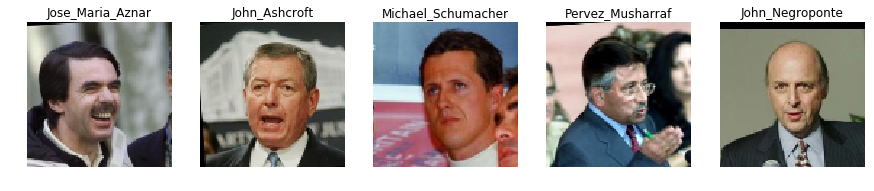

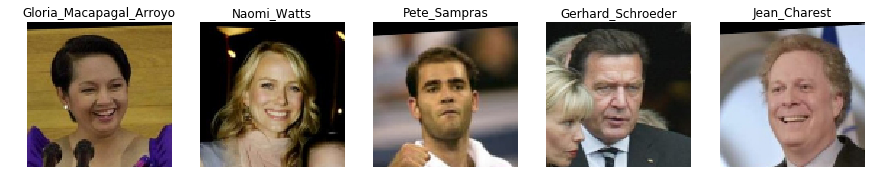

In [70]:
visualize(x_train, y_train)
visualize(x_test, y_test)

Let us now read the video classification data, as well. You have to implement function to load video data.

Function $\tt{load}$\_$\tt{video}$\_$\tt{data}$ should also return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing videos and labels. The training data is in the same format as in image classification task. The keys of testing data and labels are video ids and the values are the lists of frames and the strings with names, respectively.

In [116]:
def load_video_data(dir_name = 'Face_Recognition_data/video_classification'):
    train1, train2 = get_images(dir_name+'/train', "y_train")
    test1, test2 = get_images_video_test(dir_name+'/test')
    return train1, train2, test1, test2

def get_images_video_test(dir_name):
    import csv
    from skimage.io import imread
    from os import listdir
    from os.path import isfile, join
    # Write your code for loading images and points here
    imgs = {}
    names = {}
    file = open(dir_name + "/y_test.csv")
    reader = csv.reader(file, delimiter=',')
    headers = next(reader, None)
    for row in reader:
        list_imgs = []
        mypath = dir_name + "/videos/" + str(row[0])
        for filename in listdir(mypath):
            if isfile(join(mypath, filename)):
                im = imread(join(mypath, filename))
                list_imgs.append(im)
        imgs[row[0]] = list_imgs
        names[row[0]] = row[1]
    return imgs, names

In [117]:
video_train, train_labels, video_test, test_labels = load_video_data()
print '%d'%len(video_train), '\ttraining images'
print '%d'%len(video_test), '\ttesting videos'

729 	training images
70 	testing videos


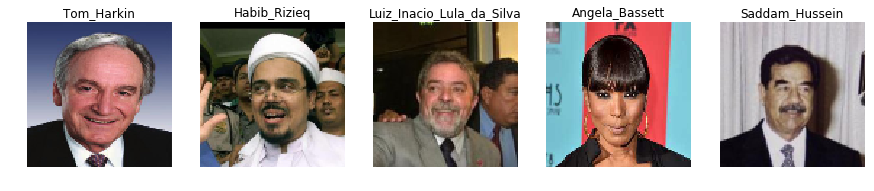

In [67]:
visualize(video_train, train_labels)

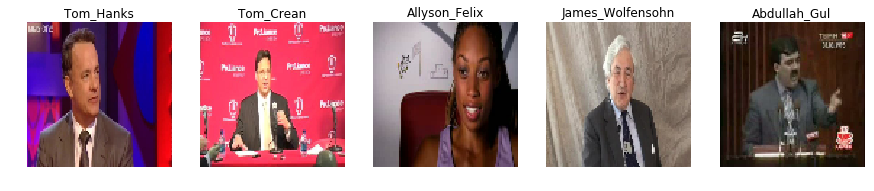

In [68]:
visualize({i:video_test[i][1] for i in video_test}, test_labels)

### Preprocessing
Getting a list of images as an input the this function should detect the face on each image, find the facial keypoints () and then crop and normalize the image according to these keypoints. The output of this function is the list of images which contain only the aligned face and should be converted to the tensor of the shape $(N, 224, 224, 3)\ $ where $N$ is the length of the initial list. You can add extra arguments to the preprocess function if necessary (i.e. flag $\tt{is}$\_$\tt{video}$ to determine if the list of images is video sequence or not).

For face detection and facial keypoint regression we will use models from previous notebooks.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout
)
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam

facial_keypoints = Sequential()

# stack some layers
facial_keypoints.add(Conv2D(16, (3,3), input_shape=(100, 100, 3), activation='relu', kernel_initializer='random_normal'))
facial_keypoints.add(MaxPooling2D(pool_size=(2,2)))
facial_keypoints.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='random_normal'))
facial_keypoints.add(MaxPooling2D(pool_size=(2,2)))
facial_keypoints.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='random_normal'))
facial_keypoints.add(MaxPooling2D(pool_size=(2,2)))

# flatten layer
facial_keypoints.add(Flatten())

# dense layers
facial_keypoints.add(Dense(256, activation='relu', kernel_initializer='random_normal'))
facial_keypoints.add(Dropout(0.3))
facial_keypoints.add(Dense(256, activation='relu', kernel_initializer='random_normal'))
facial_keypoints.add(Dropout(0.3))

# output layer
facial_keypoints.add(Dense(28, activation='linear'))

In [163]:
def find_face(points, shape):
    x = []
    y = []
    for i in range(len(points)//2):
        x.append(points[i*2])
        y.append(points[i*2 +1])
    max_x = min(np.max(x) + 0.65, 1)
    min_x = max(np.min(x) + 0.35, 0)
    max_y = min(np.max(y) + 0.65, 1)
    min_y = max(np.min(x) + 0.35, 0)
    return int(min_x * shape[0]), int(max_x * shape[0]), int(min_y * shape[1]), int(max_y * shape[1])

def preprocess_imgs(imgs):
    aux_imgs = [cv2.resize(im/255., (100, 100)) for im in imgs]
    list_points = facial_keypoints.predict(np.array(aux_imgs))
    images = []
    for i, points in enumerate(list_points):
        min_x, max_x, min_y, max_y = find_face(points, imgs[i].shape)
        images.append(cv2.resize(imgs[i][min_x:max_x, min_y:max_y, :], (224, 224)))
    return images

#preprocess_imgs([x_train["0.jpg"]])

In [13]:
facial_keypoints.load_weights("weights.h5")

In [120]:
from skimage.color import gray2rgb
from matplotlib.patches import Circle
def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image

    fig,ax = plt.subplots(1)
    ax.set_aspect('equal')
    ax.imshow(img)
    for i in range(len(points)//2):
        xx = (points[i*2] + 0.5) * 100 
        yy = (points[i*2 + 1] + 0.5) * 100
        circ = Circle((xx,yy),1)
        ax.add_patch(circ)

    

#### Visualization of preprocessing

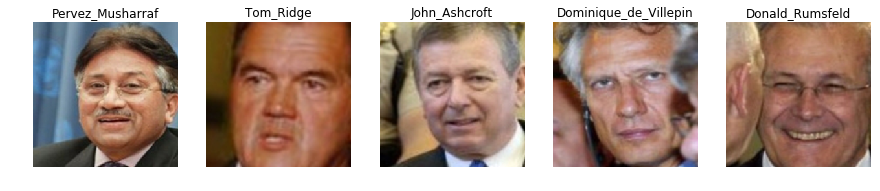

In [169]:
visualize(x_train, y_train, function = lambda x:preprocess_imgs(x)[0])

The neural network is already trained on the other face dataset. You should use this network as feature extractor to get descriptors of the faces. You can choose any hidden layer you need (or several layers) to extract features and any classification method.

In [111]:
import h5py
from keras.models import load_model
model = load_model('face_recognition_model.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)      

Here is an example of using the network as feature extractor. The shape of input tensor has to be (n_images, 224, 224, 3), so you can input several images simultaneously and get their face descriptors of shape (n_images, n_components).

In [134]:
def get_layer_output(images, layer = 'fc6'):
    assert len(images.shape)==4, 'Wrong input dimentionality!' + str(images.shape)
    assert images.shape[1:]==(224,224,3), 'Wrong input shape!'
    
    network_output = model.get_layer(layer).output
    feature_extraction_model = Model(model.input, network_output)
    
    output = feature_extraction_model.predict(images)
    return output

In [113]:
img = cv2.resize(x_train['0.jpg'], (224,224)).reshape(1,224,224,3)
out = get_layer_output(img)
print out.shape

(1, 4096)


### Training classifier


We will define class $\tt{Classifier}$ with methods $\tt{fit}$, $\tt{classify}$\_$\tt{images}$ and $\tt{classify}$\_$\tt{videos}$ in the cell below. 
The method $\tt{Classifier.fit}$ gets two dictionaries as input: train images and labels, and trains the classifier to predict the person shown on the image.
$\tt{Classifier.classify}$\_$\tt{images}$ gets the dictionary of test images (with filenames as keys) as input and should return the dictionary of the predicted labels.
$\tt{Classifier.classify}$\_$\tt{videos}$ is similar to the previous one, but gets the dictionary of test videos (with video as keys) as input.

To classify video you can combine the predictions for its frames any way you want (averaging, voting, etc.).
If video classification takes too long you can use face detector not in all the frames but every few frames while preprocessing video frames. 
Besides, sometimes the face is hardly detected on the image and the frame in which the detector works wrong can add noise to the prediction. Hence, the result of the prediction without using such frames may be better.

In [214]:
from sklearn.neighbors import KNeighborsClassifier as kNN
from skimage.io import imread
import cv2
from os.path import join
class Classifier():
    def __init__(self, nn_model, classifier=None):
        """Your implementation"""
        self.model = nn_model
        self.classifier = classifier


    def fit(self, train_imgs, train_labels):
        """Your implementation"""
        
        train_processed = preprocess_imgs(list(train_imgs.values()))
        self.classifier = kNN(n_neighbors=10)
        features_x = get_layer_output(np.array(train_processed), layer = 'fc6')
        self.labels_y = dict(list(enumerate(train_labels.values())))
        self.classifier.fit(features_x, list(self.labels_y.keys()))


    def classify_images(self, test_imgs):
        """Your implementation"""
        test_processed = preprocess_imgs(list(test_imgs.values()))
        features_x = get_layer_output(np.array(test_processed), layer = 'fc6')
        results_ids = self.classifier.predict(features_x)
        names = [self.labels_y[id] for id in results_ids]
        return dict(zip(list(test_imgs.keys()), names))

       
        
    def classify_videos(self, test_video):
        from scipy.stats import mode
        names = []
        for key, video in test_video.items():
            test_processed = preprocess_imgs(video)
            features_x = get_layer_output(np.array(test_processed), layer = 'fc6')
            self.results_ids = self.classifier.predict(features_x)
            self.most_id = mode(self.results_ids)
            names.append(self.labels_y[self.most_id[0][0]])
        return dict(zip(list(test_video.keys()), names))

Now we can build the classifier, fit it and use to predict the labels of testing images.

In [171]:
img_classifier = Classifier(model)
img_classifier.fit(x_train, y_train)
y_out = img_classifier.classify_images(x_test)

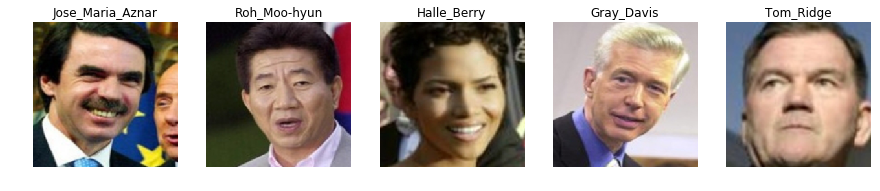

In [175]:
visualize(x_test, y_out, function = lambda x:preprocess_imgs(x)[0])

### Image classification quality


In [221]:
def check_test(output, gt):
    correct = 0.
    total = len(gt)
    for k, v in gt.items():
        if output[k] == v:
            correct += 1
    accuracy = correct / total

    return 'Classification accuracy is %.4f' % accuracy 

In [183]:
print check_test(y_out, y_test)

Classification accuracy is 0.9504


### Video classification quality


In [215]:
video_classifier = Classifier(model)
video_classifier.fit(video_train, train_labels)
y_video_out = video_classifier.classify_videos(video_test)

In [222]:
print check_test(y_video_out, test_labels)

Classification accuracy is 0.8429


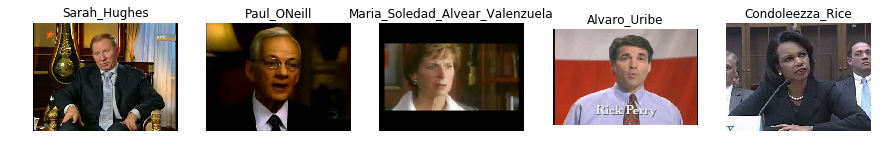

In [226]:
visualize({i:video_test[i][1] for i in video_test}, y_video_out)